# Experiment with extracting shape info from confocal images of fish embryos

In [43]:
from aicsimageio import AICSImage
import os 
import glob2 as glob

# define path to image
image_name = "2024_StayGold_10x_s018_T0"
read_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/yx1_samples/20230412/"

image_path = read_path + image_name + ".ome.tif"

# set path to segmentation
seg_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/20230412/seg_24hpf_classifier/"

# set save path
pcd_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/yx1_pcd/20230412/"

# make save directory
if not os.path.isdir(pcd_path):
    os.makedirs(pcd_path)

# get list of segmentation files
seg_list = sorted(glob.glob(seg_path + "*.tif"))

# set time points
time_ind = 0
labelObject = AICSImage(seg_list[time_ind])


In [44]:
import plotly.graph_objects as go
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
import plotly.express as px
from skimage import data
from skimage import filters
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import black_tophat, skeletonize, convex_hull_image 
from skimage.morphology import disk
import skimage
import scipy
import numpy as np

# get resolution
res_raw = labelObject.physical_pixel_sizes
res_array = np.asarray(res_raw)
res_array = np.insert(res_array, 0, 1)
pixel_size_z = 20#res_array[1]
pixel_size_x = 1#res_array[2]
pixel_size_y = 1#res_array[3]

# extract raw image
labelData = np.squeeze(labelObject.data)

# resize image such that voxels are isotropic
z_rs_factor = pixel_size_z/pixel_size_x
ds_factor = 4
pixel_size_new = pixel_size_x / ds_factor
labelData_rs = scipy.ndimage.zoom(labelData, [z_rs_factor/ds_factor, 1/ds_factor, 1/ds_factor])

labelDataBin = labelData_rs>0

keep_indices = np.where(labelDataBin ==1)

z_grid3, y_grid3, x_grid3 = np.meshgrid(range(0, labelDataBin.shape[0]), 
                                        range(0, labelDataBin.shape[1]), 
                                        range(0, labelDataBin.shape[2]),
                                       indexing="ij")

# # calculate position of max point for each
x_surf3 = x_grid3[keep_indices]
y_surf3 = y_grid3[keep_indices]
z_surf3 = z_grid3[keep_indices]


/var/folders/m7/tpjttxb92tl8b4c9svgvgby00000gn/T/ipykernel_24037/3392209304.py:3: RuntimeWarning: invalid value encountered in divide
  max_z_plane = np.divide(np.sum(np.multiply(labelDataBin,z_grid3), axis=0), np.sum(labelDataBin, axis=0))


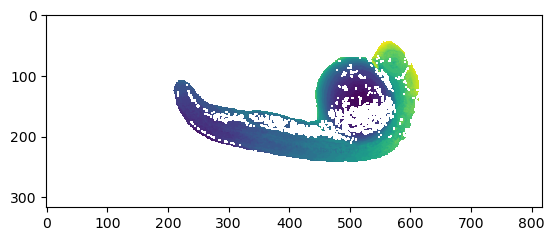

In [45]:
# vizualise
max_z_project = np.max(labelDataBin, axis=0)
max_z_plane = np.divide(np.sum(np.multiply(labelDataBin,z_grid3), axis=0), np.sum(labelDataBin, axis=0))
max_z_plane = max_z_plane.astype(float)
max_z_plane[np.where(max_z_project==0)] = np.nan

plt.imshow(max_z_plane)

Attempt to infer a surface using marching cubes

**Can we use linear interpolation to fill label gaps?**

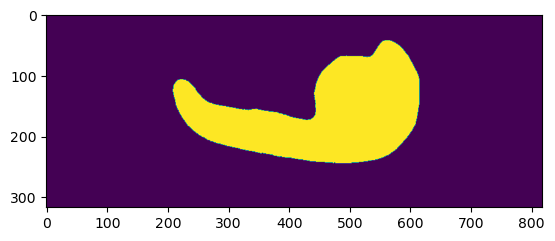

In [46]:
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)

# first, generate 3D mask to identify interior pixels that we wish to interpolate
fish_mask = (np.max(labelDataBin, axis=0) == 1)*1

# use morphological closure operation to fill in shape
footprint = disk(13)
fp_small = disk(2)
fish_closed = closing(fish_mask > 0, footprint)
fish_clean = skimage.morphology.remove_small_objects(label(fish_closed), min_size=64)
fish_eroded = skimage.morphology.binary_erosion(fish_clean, fp_small)
# plt.imshow(fish_mask)
plt.imshow(fish_clean)

Use known z label locations to interpolate missing ones

In [9]:
from scipy.interpolate import LinearNDInterpolator

y_grid2, x_grid2 = np.meshgrid(
                                range(0, max_z_plane.shape[0]), 
                                range(0, max_z_plane.shape[1]),
                                indexing="ij")

x_flat = x_grid2.flatten()
y_flat = y_grid2.flatten()

# generate diplacement vectors
max_z_plane_vals = max_z_plane.flatten()
mask_flat = (fish_clean.flatten() > 0)*1
mask_er = (fish_eroded.flatten() > 0)*1

ref_x = x_flat[np.where((~np.isnan(max_z_plane_vals)) & (mask_flat==1))]
ref_y = y_flat[np.where((~np.isnan(max_z_plane_vals)) & (mask_flat==1))]
ref_z = max_z_plane_vals[np.where((~np.isnan(max_z_plane_vals)) & (mask_flat==1))]

query_x = x_flat[np.where(mask_flat==1)]
query_y = y_flat[np.where(mask_flat==1)]
query_x_er = x_flat[np.where(mask_er==1)]
query_y_er = y_flat[np.where(mask_er==1)]

# interpolate
interp_z = LinearNDInterpolator(list(zip(ref_x, ref_y)), ref_z)
query_z = interp_z(query_x, query_y)
            

# disp_x = interp_x(source_xyz_norm[:, 0], source_xyz_norm[:, 1], source_xyz_norm[:, 2])
# disp_y = interp_y(source_xyz_norm[:, 0], source_xyz_norm[:, 1], source_xyz_norm[:, 2])
# disp_z = interp_z(source_xyz_norm[:, 0], source_xyz_norm[:, 1], source_xyz_norm[:, 2])

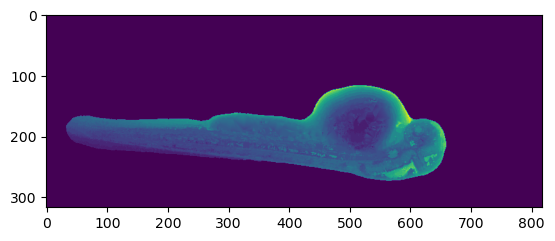

In [10]:
surf_mask_array_raw = np.zeros(labelData_rs.shape)
surf_mask_array_raw[np.round(query_z).astype(int), query_y, query_x] = 1

surf_mask_array = surf_mask_array_raw.copy() 
# surf_mask_array[40, query_y_er, query_x_er] = 1

plt.imshow(np.argmax(surf_mask_array, axis=0))

Maybe alphashape?

In [33]:
from alphashape import alphashape
import open3d as o3d
z_flat = query_z#max_z_plane.flatten()
plot_x = query_x#[np.where((~np.isnan(max_z_plane_vals) & (mask_flat>0)))]
plot_y = query_y#[np.where((~np.isnan(max_z_plane_vals) & (mask_flat>0)))]
plot_z = z_flat#[np.where((~np.isnan(max_z_plane_vals) & (mask_flat>0)))]

surf_flat = surf_mask_array.flatten()
keep_indices = np.where(surf_mask_array>0)
# x3 = x_grid3[keep_indices]
# y3 = y_grid3[keep_indices]
# z3 = z_grid3[keep_indices]
# generate smooth bottom
base_array = np.empty((len(plot_x), 3))
base_array[:, 0] = plot_x
base_array[:, 1] = plot_y
base_array[:, 2] = plot_z + 10

xyz_array3 = np.concatenate((plot_x[:, np.newaxis], plot_y[:, np.newaxis], plot_z[:, np.newaxis]), axis=1)
# xyz_array3 = np.concatenate((x_surf3[:, np.newaxis], y_surf3[:, np.newaxis], z_surf3[:, np.newaxis]), axis=1)
xyz_array3 = np.concatenate((xyz_array3, base_array), axis=0)
xyz_array3_norm = xyz_array3.copy()
xyz_array3_norm = xyz_array3_norm / np.max(xyz_array3_norm)

print(xyz_array3_norm.shape)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_array3_norm)
pcd_ds = pcd.voxel_down_sample(voxel_size=0.0001)

xyz_ds = np.asarray(pcd_ds.points)
print(xyz_ds.shape)
alpha_fish = alphashape(xyz_ds, alpha=65)
alpha_fish.show()

(103464, 3)
(103464, 3)


23-Apr-23 18:41:56 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
23-Apr-23 18:41:56 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
23-Apr-23 18:41:56 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
23-Apr-23 18:41:56 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
23-Apr-23 18:41:56 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
23-Apr-23 18:41:57 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
23-Apr-23 18:41:57 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
23-Apr-23 18:41:57 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
23-Apr-23 18:41:57 - root     - WARNING  - Singular matrix. Likely caused by all points lying in an N-1 space.
2

In [38]:
import trimesh
# trimesh.repair.fill_holes(alpha_fish)
# print(test)
mesh_out = trimesh.smoothing.filter_taubin(alpha_fish, iterations=10)
# mesh_out = trimesh.smoothing.get_vertices_normals(mesh_out)
mesh_out.show()
print(mesh_out)

<trimesh.Trimesh(vertices.shape=(14850, 3), faces.shape=(30044, 3))>


In [39]:
test = trimesh.load_mesh('test_mesh.stl')
test.show()

2023-04-22 15:12:51.261 python[9854:19244804] GLDRendererMetal command buffer completion error: Error Domain=MTLCommandBufferErrorDomain Code=8 "Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)" UserInfo={NSLocalizedDescription=Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)}


(array([[  3.7603967, 117.56846  , 503.98685  ],
        [  4.       , 116.5      , 505.       ],
        [  3.5      , 117.       , 505.       ],
        ...,
        [ 79.50874  , 182.1447   , 527.65546  ],
        [ 79.5      , 182.       , 524.       ],
        [ 79.5      , 184.       , 524.       ]], dtype=float32),
 array([[    0,     1,     2],
        [    1,     3,     2],
        [    4,     3,     1],
        ...,
        [35585, 35509, 35584],
        [35585, 35586, 35509],
        [35586, 35512, 35509]]))
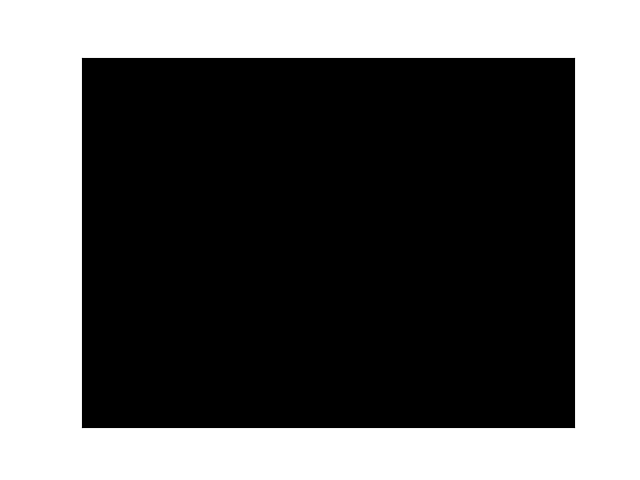

In [145]:
# smoothed_surface = nppas.smooth_surface_moving_least_squares_2d(e_surf2)
# smoothed_surface
simplified_surface = nppas.decimate_quadric(e_surf2, fraction=0.1)
simplified_surface

 ━━━━━━━━━━━━━━━━━━━━━━ elapsed: 4s (6052.3 it/s)             (6055.3 it/s)         working ...


(array([[  4.0246654, 124.72453  , 503.12546  ],
        [  4.0425496, 124.6124   , 504.21643  ],
        [  3.5327873, 124.627754 , 504.16678  ],
        ...,
        [ 82.754814 , 242.14297  , 443.27625  ],
        [ 82.267006 , 242.60194  , 445.63925  ],
        [ 82.23507  , 243.1522   , 445.1132   ]], dtype=float32),
 array([[    0,     1,     2],
        [    1,     3,     2],
        [    4,     3,     1],
        ...,
        [25685, 25687, 25688],
        [25681, 24489, 24476],
        [25681, 24488, 24489]]))
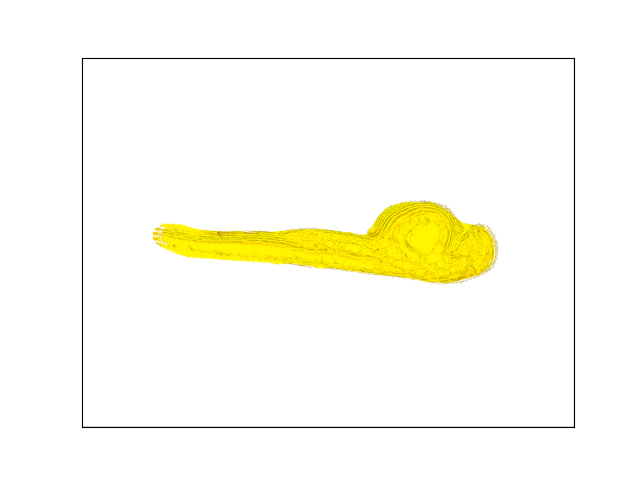

In [19]:
smoothed_surface = nppas.smooth_surface_moving_least_squares_2d(simplified_surface, smoothing_factor=0.2)
smoothed_surface

Well...let's try a different method

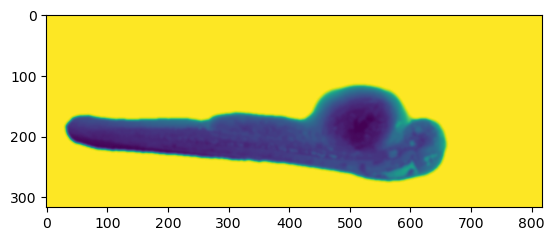

In [12]:
from skimage.filters import gaussian

surf_mask_array_smooth = np.argmax(surf_mask_array_raw.copy(), axis=0)
surf_mask_array_smooth[np.where(surf_mask_array_smooth==0)] = 84
surf_mask_array_smooth = gaussian(surf_mask_array_smooth, sigma=2, preserve_range=True)
plt.imshow(surf_mask_array_smooth)
new_z = surf_mask_array_smooth[query_y_er, query_x_er]

In [13]:
xyz_array = np.concatenate((query_x_er[:, np.newaxis], query_y_er[:, np.newaxis], new_z[:, np.newaxis]), axis=1)

base_array = np.empty((len(query_x_er), 3))
base_array[:, 0] = query_x_er
base_array[:, 1] = query_y_er
base_array[:, 2] = new_z + 20

# xyz_array3 = np.concatenate((plot_x[:, np.newaxis], plot_y[:, np.newaxis], plot_z[:, np.newaxis]), axis=1)
# xyz_array3 = np.concatenate((x_surf3[:, np.newaxis], y_surf3[:, np.newaxis], z_surf3[:, np.newaxis]), axis=1)
xyz_array3 = np.concatenate((xyz_array, base_array), axis=0)
xyz_array3_norm = xyz_array3.copy()
xyz_array3_norm = xyz_array3_norm / np.max(xyz_array3_norm)

print(xyz_array3_norm.shape)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_array3_norm)
pcd_ds = pcd.voxel_down_sample(voxel_size=0.0001)
cl, ind = pcd_ds.remove_statistical_outlier(nb_neighbors=20,
                                                        std_ratio=2.0)

xyz_ds = np.asarray(pcd_ds.points)
print(xyz_ds.shape)
alpha_fish = alphashape(xyz_ds[ind], alpha=50)
alpha_fish.show()

(98134, 3)
(98134, 3)


In [46]:
alpha_fish

<trimesh.Trimesh(vertices.shape=(2330, 3), faces.shape=(4656, 3))>

In [143]:
import pyvista as pv
import open3d as o3d

xyz_array = np.concatenate((query_x_er[:, np.newaxis], query_y_er[:, np.newaxis], new_z[:, np.newaxis]), axis=1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz_array)
pcd_ds = pcd.voxel_down_sample(voxel_size=1)

xyz_ds = np.asarray(pcd_ds.points)
pv_cloud = pv.PolyData(xyz_ds)
print(xyz_ds.shape)
print(xyz_array.shape)


alpha = 10
dl_3d_mesh = pv_cloud.delaunay_2d(alpha=alpha)
# # dl_3d_mesh = alphashape.alphashape(xyz_in, alpha=8)
# dl_3d_mesh.fill_holes(200, inplace=True)
smooth = dl_3d_mesh.smooth_taubin(n_iter=5000)
smooth.plot(jupyter_backend='ipygany', scalars=xyz_ds[:, 2])

(49272, 3)
(49272, 3)


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options=(('BrBG'…

In [46]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

In [47]:
(mnist.data.shape)

(70000, 784)

(array([[  1.3463652,  46.780983 ,  22.672756 ],
        [  1.8602695,  46.668724 ,  23.168442 ],
        [  1.5820512,  47.105965 ,  22.951086 ],
        ...,
        [ 40.5      , 130.       , 243.       ],
        [ 40.499744 , 129.98375  , 248.0003   ],
        [ 40.499638 , 129.98549  , 250.00023  ]], dtype=float32),
 array([[   2,    1,    0],
        [   2,    0,    3],
        [   4,    0,    1],
        ...,
        [2177, 2131, 2129],
        [2185, 2183, 2237],
        [2184, 2237, 2183]]))
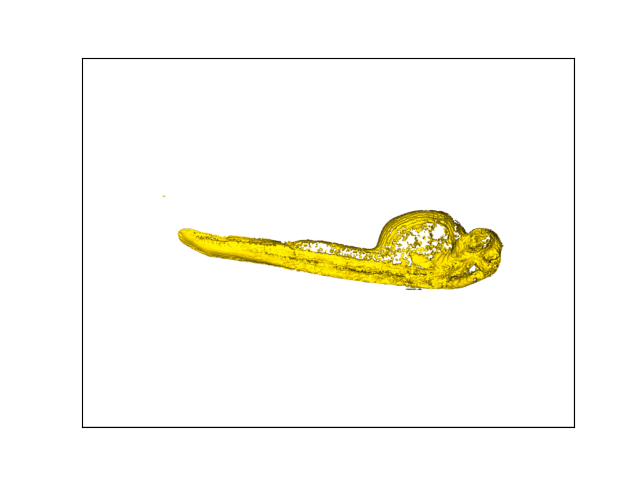

In [11]:
nppas.fill_holes_in_surface(smoothed_surface, size_limit=300)

(array([[  2.8944879,  89.52143  , 266.86444  ],
        [  2.6492836,  93.284424 , 271.37393  ],
        [  2.0208771,  94.426254 , 267.82535  ],
        ...,
        [ 35.18774  , 103.28049  , 318.88617  ],
        [ 33.28581  , 106.40932  , 320.48843  ],
        [ 37.313377 , 105.401405 , 314.73264  ]], dtype=float32),
 array([[  0,   1,   2],
        [  3,   4,   5],
        [  6,   7,   8],
        ...,
        [796, 794, 792],
        [791, 795, 794],
        [796, 791, 794]]))
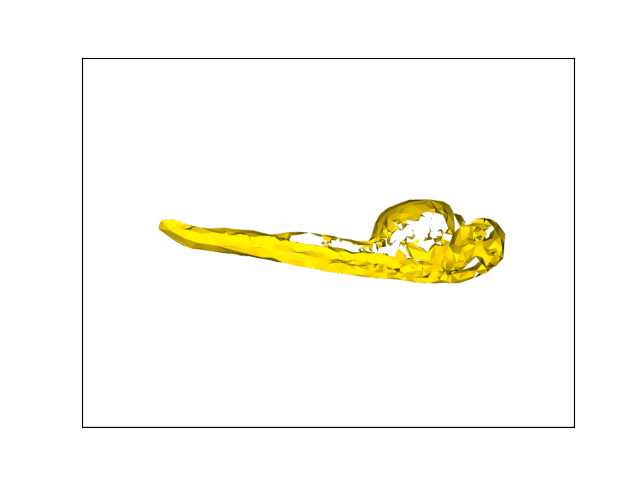

In [31]:
simplified_surface2 = nppas.decimate_quadric(smoothed_surface, fraction=0.01)
simplified_surface2

**Let's see if we can fill gaps using linear interpolation**

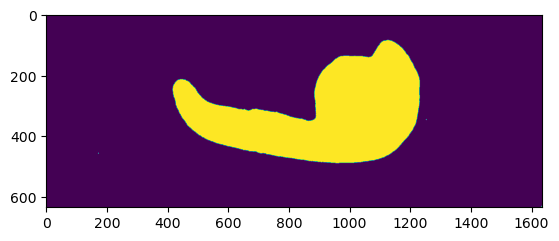

In [36]:
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)

# first, generate 3D mask to identify interior pixels that we wish to interpolate
fish_mask = (np.max(imDataBin, axis=0) == 1)*1

# use morphological closure operation to fill in shape
footprint = disk(15)
fish_closed = closing(fish_mask, footprint)

# plt.imshow(fish_mask)
plt.imshow(fish_closed)


In [ ]:
from scipy import interpolate

# identify "holes" for which not a single pixel nonzero exists 
query_indices = np.where((fish_closed==1) & (fish_mask!=1))[0]
ref_indices = np.where(fish_mask==1)[0]
print(len(candidate_indices))
print(len(ref_indices))

f = interpolate.interp2d(xyz_array2[:, 0], xyz_array2[:, 1], xyz_array2[:, 2], kind='linear')
x_query = x_grid2[query_indices]
y_query = y_grid2[query_indices]
z_query = f(x_query, y_query)

Try fitting to the surface points only

(array([[0.0000e+00, 6.2950e+02, 1.6340e+03],
        [5.0000e-01, 6.3000e+02, 1.6340e+03],
        [0.0000e+00, 6.3000e+02, 1.6335e+03],
        ...,
        [1.6900e+02, 3.9800e+02, 1.1795e+03],
        [1.6900e+02, 3.9800e+02, 1.1805e+03],
        [1.6900e+02, 3.9850e+02, 1.1800e+03]], dtype=float32),
 array([[     2,      1,      0],
        [     1,      3,      0],
        [     5,      4,      1],
        ...,
        [536716, 536713, 536714],
        [536717, 536715, 536713],
        [536717, 536713, 536716]]))
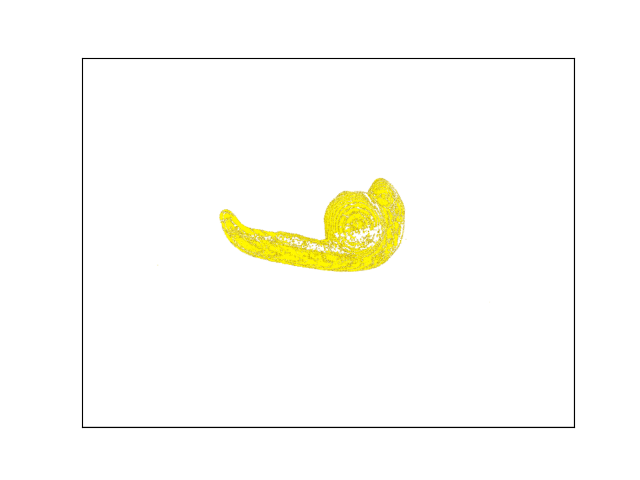

In [24]:
surf_mask_array = np.zeros(imData_rs.shape)
sub_i = np.roll(xyz_array2, 1, axis=1)
surf_indices = np.ravel_multi_index((1,2,2), imData_rs.shape)
surf_mask_array[xyz_array2[:, 2], xyz_array2[:, 1], xyz_array2[:, 0]] = 1

e_surf = nppas.all_labels_to_surface(surf_mask_array)
e_surf

In [30]:
e_surf.__dict__.keys()

dict_keys(['library_name', 'help_url'])

**Attempt 2:** downsample, interpolate, and then infer mesh

In [ ]:
# import numpy as np
# import scipy
# from scipy import interpolate


# f = interpolate.interp2d(xyz_ds_in[:, 0], xyz_ds_in[:, 1], xyz_ds_in[:, 2], kind='linear')


In [ ]:
# npoints = 150
# xg = np.linspace(np.min(xyz_ds_in[:, 0]), np.max(xyz_ds_in[:, 0]), npoints)
# yg = np.linspace(np.min(xyz_ds_in[:, 1]), np.max(xyz_ds_in[:, 1]), npoints)

# x_grid, y_grid = np.meshgrid(xg, yg)

# znew = f(xg, yg)

# xyz_interp = np.concatenate((np.reshape(x_grid, (x_grid.size, 1)), 
#                              np.reshape(y_grid, (x_grid.size, 1)),
#                              np.reshape(znew, (x_grid.size, 1))),
#                              axis=1)

# xyz_interp_filt = xyz_interp[np.where(xyz_interp[:, 2]<=350)]
# xyz_interp_filt = xyz_interp_filt[xyz_interp_filt[:, 2]>0]
# pv_cloud_interp = pv.PolyData(xyz_interp_filt)
# pv_cloud_interp.plot(jupyter_backend='ipygany')